In [1]:
import pyodbc
import pandas as pd
from IPython.display import display, Markdown
import os
from contextlib import contextmanager
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

dbconn = os.environ.get('DBCONN', None)
if dbconn is None:
    display("No SQL credentials. Check that the file 'environ.txt' is present. Refer to readme for further information")
else:
    dbconn = dbconn.strip('"')
    
    
@contextmanager
def closing_connection(dbconn):
    cnxn = pyodbc.connect(dbconn)
    try:
        yield cnxn
    finally:
        cnxn.close()

## Import codelists

In [2]:
display(Markdown("### Warfarin Codelist"))
codelist = pd.read_csv(os.path.join('..','local_codelists','warfarin_codelist.csv'))

def codelist_to_tuple(codelist):
    display(Markdown(f"Code count = {len(codelist)}"))
    if len(codelist)>1:
        out = tuple(codelist["id"].astype("str"))
    else: # don't create tuple if only one code
        out = str(tuple(codelist["id"].astype("str"))).replace(",","")
    return out

def drug_codelist(codelist, return_dmdid=False):
    codes = codelist_to_tuple(codelist)
    
    if return_dmdid==True:
        dmd = ", DMD_ID"   # need DMD_IDs for DOACs only
    else:
        dmd = ""
    
    query = f'''SELECT
    MultilexDrug_ID {dmd}
    FROM
      MedicationDictionary
    WHERE
      DMD_ID IN {codes}
    '''

    with closing_connection(dbconn) as connection:
        out = pd.read_sql(query, connection)

    out2 = tuple(out["MultilexDrug_ID"]) # convert to tuple for use in SQL strings
    display(Markdown(f"Drug ID count = {len(out2)}"))
    return out, out2
    

_, warf = drug_codelist(codelist, return_dmdid=False)


display(Markdown("### DOAC Codelist"))
codelist = pd.read_csv(os.path.join('..','local_codelists','doac_codelist.csv'))
doac_full, doac = drug_codelist(codelist, return_dmdid=True)
doac_full["DMD_ID"] = doac_full["DMD_ID"].astype(int)

# join Multilex IDs with chemical groups for lookup table
doac_full = doac_full.merge(codelist[["id", "chemical"]], left_on="DMD_ID", right_on="id").drop(["DMD_ID", "id"], 1)


# INR codelist
display(Markdown("### INR Codelist"))
codelist = pd.read_csv(os.path.join('..','codelists','opensafely-international-normalised-ratio-inr.csv'))
inr_codes = codelist_to_tuple(codelist)

# INR codelist
display(Markdown("### High INR Codelist"))
codelist = pd.read_csv(os.path.join('..','codelists','opensafely-high-international-normalised-ratio-inr.csv'))
high_inr = codelist_to_tuple(codelist)

### Warfarin Codelist

Code count = 132

Drug ID count = 128

### DOAC Codelist

Code count = 26

Drug ID count = 74

### INR Codelist

Code count = 1

### High INR Codelist

Code count = 2

## Create function for plotting charts

In [3]:
def plot_line_chart(dfs, titles, ylabels=None, loc='lower left', ymins=None):
    '''
    Plot a line chart for each df in list. Plots each column as a separate line. Index of each df should be individual months (datetimes). 
    
    INPUTS:
    dfs (list): dataframes to plot
    titles (list): strings for titles
    loc (str): location to place legend on chart
    ylabels (dict): any ylabels to change from the default 'Number of patients', e.g. {1: 'Rate per 1000'}
    ymins (dict): adjust lower y axis limit if required
    
    OUTPUTS:
    chart
    '''
    # fill None type dict variables with empty dicts
    if ylabels is None:
        ylabels = {}
        
    if ymins is None:
        ymins = {}
        
    # count how many dataframes are being plotted
    charts = len(dfs)
    
    fig, axs = plt.subplots(1, charts, figsize=(10*charts,8))
    
    for n, (title, dfp) in enumerate(zip(titles, dfs)):
        
        # if more than one chart is to be plotted, then select each ax in turn
        if charts > 1:
            ax = axs[n]
            fontsizing = 1.25
            titlesizing = 1.1
        else:
            ax = axs
            fontsizing = 1
            titlesizing = 1
            
        # use given ylabel for this chart if it exists, else use default
        if n in ylabels: 
            ylabel = ylabels[n]
        else:
            ylabel = 'Number of patients'
            
        # use given ymin for this chart if it exists, else use default (0)
        if n in ymins: 
            ymin = ymins[n]
        else:
            ymin = 0
        
        # if all values are over 1000, convert data to thousands and label axis appropriately
        if dfp.min().min() > 1000: 
            dfp = dfp/1000
            ylabel = f"{ylabel} (thousands)"
        else:
            dfp = dfp
            ylabel = ylabel
        
        dfp.index = pd.to_datetime(dfp.index)
        
        # find columns that aren't standard deviations
        measures = [s for s in dfp.columns if "stdev" not in s]
        ymax = [0]
        
        # if more than one line is to be plotted, then add a legend     
        if len(measures)>1:
            legend=True
        else:
            legend=False
        
        # if no error bars to plot, use a standard plot function
        if len(measures) == len(dfp.columns):
            plot = dfp.plot(ax=ax, legend=legend)
        # else use errorbar plot
        else:
            for m in measures:
                ax.errorbar(dfp.index, dfp[m], yerr=dfp[f"{m}_stdev"], elinewidth=0.5, capsize=2, label=m)
                ymax.append((dfp[m]+dfp[f"{m}_stdev"]).max())
                
        ##### formatting ########
        
        # set date formatting for major tick labels (years)  - months in between will be minor tick marks
        ticklabels = [item.strftime('%b %y') for item in dfp.index]
        ticklabels = [s for s in ticklabels if "Jan" in s] # januarys only
        # use ticker instead of DateFormatter which parses pandas dates incorrectly (2020 -> 51)
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
        ax.set_xlim([dfp.index.min(), date(2020,8,30)])
        ax.tick_params(axis='x', size=10*fontsizing)
        
        ax.axvline(date(2020,3,26), color='k', linestyle=":", alpha=0.8)
        ax.text(date(2020,3,31), ymin*1.001, "NHSE directive", rotation=90, fontsize=11*fontsizing)
        
        ax.set_ylabel(ylabel, size=14*fontsizing)
        ax.set_xlabel("Month", size=14*fontsizing)
        ylim = max(dfp.max().max(), max(ymax))*1.05
        ax.set_ylim([ymin,ylim])
        ax.set_title(title, size=18*titlesizing)
        
        if legend==True:
            ax.legend(loc=loc, fontsize=14*fontsizing)
        else:
            pass
        
    plt.show()

## Create function to generate dummy data

In [4]:

# randomly assign dates to patients
def generate_dummy_data(date_fields, month_field=None, multiple_choice=None, exclusive_choices=None, size=1000):
    
    '''Generate a dataframe of dummy data
    
    Inputs:
    date_fields (list): list of column names to generate and populate with dates
    month_field (str): name of single column from which to calculate a month ("YYYY-MM-01")
    multiple_choice (dict): fields to generate, and lists of possible values to populate with. Note these can overlap i.e. patients can have several of the values given, and no patients in the output will have none
    exclusive_choices (dict): fields to generate, and lists of possible values to populate with. Each row of data will be assigned one value. 
    size (int): number of patient IDs to initially generate
    '''
    
    p2 = pd.DataFrame()
    
    # create a list of numeric patient ids (starting from "1000")
    patient_ids = pd.Series(np.arange(1000,1000+size))
    # create a list of dates to select randomly from
    dates = pd.to_datetime(pd.Series(pd.date_range(start='2020-01-01', end='2020-07-01', periods=size*2), name="dates").dt.date)
    
    patient_subset = patient_ids
    
    if multiple_choice is None:
        multiple_choice = {}
        
    for c in multiple_choice: # e.g. {"anticoag":["warfarin","doac"]} each patient can be duplicted here to have several of each choice
        patient_subset = patient_subset.sample(int(patient_ids.shape[0]*0.5), random_state=1, replace=True)
        for item in multiple_choice[c]:
            out = pd.DataFrame(patient_subset.sample(int(patient_subset.shape[0]*5), random_state=1, replace=True).reset_index(drop=True), columns=["Patient_ID"])
            out[c] = item
            p2 = p2.append(out).reset_index(drop=True)
    
    if exclusive_choices is None:
        exclusive_choices = {}
        
    for i, c in enumerate(exclusive_choices): # e.g. {"flag":[0,1]}
        out = pd.Series(exclusive_choices[c], name=c).sample(p2.shape[0],replace=True).reset_index()
        p2 = pd.concat([p2, out], axis=1, sort=False).drop("index",1)
    
    if len(p2) == 0: # if no choices were supplied, begin populating df with the generated list of patient IDs
        p2["Patient_ID"] = patient_ids
    
    for d in date_fields:    # assign dates from generated date list into each required date field
        p2[d] = dates.sample(n=p2.shape[0], replace=True).reset_index(drop=True).astype(str)
       
    # convert dates to first of month
    if month_field is not None:
        p2[f"{month_field}_month"] = p2[month_field].str[:-2] + "01"
        
    return p2.sort_values(by="Patient_ID")


def insert_dummy_data(dummy_data, table, rows=1000):
    ''' Insert dummy data into specified SQL temp table'''
    
    # creating column list for insertion
    cols = ", ".join([str(i) for i in dummy_data.columns.tolist()])
    for i,row in dummy_data.head(rows).iterrows():
        sql = f"INSERT INTO {table} ({cols}) VALUES {tuple(row)}"
        connection.execute(sql) 


date_fields=["StartDate", "EndDate"]
multiple_choice={"anticoag":["warfarin","DOAC"]} 
exclusive_choices={"year":["2019","2020"]}
dummy_data = generate_dummy_data(date_fields, month_field="StartDate", multiple_choice=multiple_choice, exclusive_choices=exclusive_choices)
dummy_data

,Patient_ID,anticoag,year,StartDate,EndDate,StartDate_month
1450,1001,warfarin,2020,2020-05-27,2020-06-20,2020-05-01
3950,1001,DOAC,2020,2020-01-15,2020-03-01,2020-01-01
4427,1001,DOAC,2019,2020-05-21,2020-05-17,2020-05-01
3910,1001,DOAC,2020,2020-06-22,2020-06-07,2020-06-01
1927,1001,warfarin,2020,2020-01-25,2020-05-16,2020-01-01
...,...,...,...,...,...,...
2261,1999,warfarin,2019,2020-06-05,2020-02-03,2020-06-01
2340,1999,warfarin,2020,2020-01-10,2020-02-12,2020-01-01
1229,1999,warfarin,2019,2020-04-22,2020-03-20,2020-04-01
4761,1999,DOAC,2019,2020-04-30,2020-03-05,2020-04-01


# Total patients with anticoagulants per month, and duplicate issues

In [5]:

# Warfarin and DOAC patients
sql1 = f'''SELECT
Patient_ID,
CASE WHEN MultilexDrug_ID in {warf} THEN 'warfarin' ELSE 'DOAC' END AS anticoag,
StartDate,
DATEFROMPARTS(YEAR(StartDate),MONTH(StartDate),1) AS Startmonth,
MAX(EndDate) AS EndDate
INTO #allpts
FROM
  MedicationIssue
WHERE
  StartDate >= '20190101' AND 
  StartDate < DATEFROMPARTS(YEAR(GETDATE()),MONTH(GETDATE()),1) -- select only issues occurring up to end of last full month
  AND
  (MultilexDrug_ID in {warf} OR MultilexDrug_ID in {doac})
GROUP BY 
Patient_ID,
CASE WHEN MultilexDrug_ID in {warf} THEN 'warfarin' ELSE 'DOAC' END,
StartDate,
DATEFROMPARTS(YEAR(StartDate),MONTH(StartDate),1)'''


## total patients with each anticoagulant issued each month
query1 = '''SELECT Startmonth, anticoag, COUNT(DISTINCT Patient_ID) AS patient_count FROM #allpts
GROUP BY Startmonth, anticoag'''
## total patients with ANY anticoagulant issued each month
query2 = '''SELECT Startmonth, COUNT(DISTINCT Patient_ID) AS patient_count FROM #allpts
GROUP BY Startmonth'''

# total patients with doac and warfarin issued same day
query3 = f'''SELECT d.Startmonth, COUNT(DISTINCT d.Patient_ID) AS Duplicate_issues, 
SUM(CASE WHEN w.StartDate = w.EndDate OR d.StartDate = d.EndDate THEN 1 ELSE 0 END) AS one_cancelled
FROM #allpts d
INNER JOIN (SELECT * FROM #allpts WHERE anticoag = 'warfarin') w 
  ON d.Patient_ID = w.Patient_ID and d.StartDate = w.StartDate
WHERE d.anticoag = 'DOAC'
GROUP BY d.Startmonth
ORDER BY d.Startmonth
'''

with closing_connection(dbconn) as connection:
    connection.execute(sql1)

    # insert linkable data if using dummy data
    if 'OPENCoronaExport' in dbconn:
        date_fields=["StartDate", "EndDate"]
        choices={"anticoag":["warfarin","DOAC"]}
        dummy_data = generate_dummy_data(date_fields, month_field="StartDate", multiple_choice=choices)
        # small fixes to dummy data:
        dummy_data = dummy_data.rename(columns={"StartDate_month":"Startmonth"})
        dummy_data["EndDate"] = np.where(dummy_data["EndDate"]<dummy_data["StartDate"],dummy_data["StartDate"], dummy_data["EndDate"])
        insert_dummy_data(dummy_data, "#allpts")

    
    df1 = pd.read_sql(query1, connection)
    df2 = pd.read_sql(query2, connection)
    df3 = pd.read_sql(query3, connection)

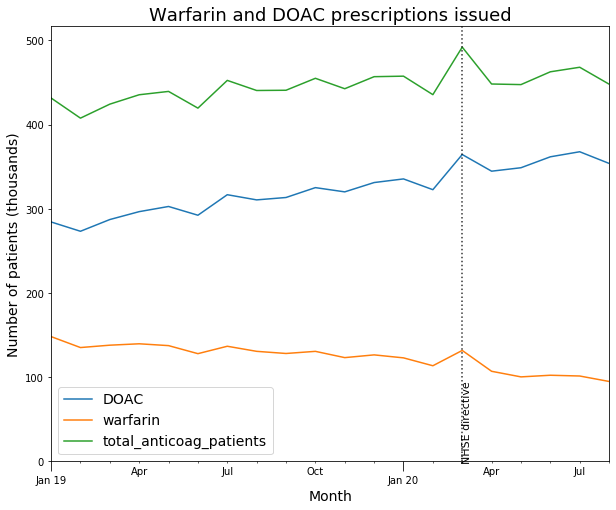

In [6]:
out1 = df1.set_index(["Startmonth","anticoag"]).unstack().droplevel(0, axis=1).reset_index().set_index("Startmonth")
out1 = out1.rename(columns={"doac":"doac_patients", "warf":"warf_patients"})

out2 = df2.set_index("Startmonth")
out3 = df3.set_index("Startmonth")

out1 = out1.join(out2)
out1 = out1.rename(columns={"patient_count":"total_anticoag_patients"})

# export data to csv
out1.replace([1,2,3,4,5], np.NaN).to_csv(os.path.join("..","output","warf_doac_issues.csv"))

# plot chart
titles = ["Warfarin and DOAC prescriptions issued"]
plot_line_chart([out1], titles)       
    
# patients having both Warfarin and DOAC prescriptions issued on the same day (displayed later)  
out4 = out1.join(out3)


# Patients with DOAC and warfarin repeats

### Of patients who had either anticoagulant issued each month, *who has repeats* and were they *started together*


In [7]:

# all patients with either a doac or warfarin issued, per month

sql1 = f'''SELECT DISTINCT
Patient_ID,
DATEFROMPARTS(YEAR(StartDate), MONTH(StartDate),1) AS issuemonth
INTO #temp
FROM
  MedicationIssue
WHERE
  StartDate >= '20190101' AND 
  StartDate < DATEFROMPARTS(YEAR(GETDATE()),MONTH(GETDATE()),1) -- select only issues occurring up to end of last full month
  AND
  (MultilexDrug_ID in {warf} OR MultilexDrug_ID in {doac})'''


# Repeat prescriptions to temp table
sql2 = f'''SELECT DISTINCT
Patient_ID,
CASE WHEN MultilexDrug_ID in {warf} THEN 'warfarin' ELSE 'DOAC' END AS 'anticoag',
StartDate,
EndDate
INTO #rpts2
FROM
  MedicationRepeat
WHERE
  EndDate >= '20190101' AND
  (MultilexDrug_ID in {warf} OR MultilexDrug_ID in {doac})'''


# join repeats to patients
sql3 = f'''SELECT
a.Patient_ID,
a.issueMonth,
CASE WHEN d.StartDate IS NOT NULL THEN 1 ELSE 0 END AS doac_repeat,
CASE WHEN w.StartDate IS NOT NULL THEN 1 ELSE 0 END AS warf_repeat,
--COUNT(d.StartDate) OVER (PARTITION BY a.Patient_ID, a.IssueMonth) AS doacCount,
--COUNT(w.StartDate) OVER (PARTITION BY a.Patient_ID, a.IssueMonth) AS warfCount,
--d.StartDate as doacstart,
--w.StartDate as warfstart,
--d.EndDate as doacend,
--w.EndDate as warfend,
CASE WHEN d.EndDate >= '99990101' THEN 1 ELSE 0 END AS doac_open_ended,
CASE WHEN w.EndDate >= '99990101' THEN 1 ELSE 0 END AS warf_open_ended,
CASE WHEN d.EndDate >= '99990101' AND w.EndDate >= '99990101' THEN 1 ELSE 0 END AS both_open_ended,
CASE WHEN w.StartDate = d.Startdate THEN 1 ELSE 0 END AS started_same_date,
CASE WHEN w.StartDate = d.Startdate AND (w.StartDate = w.EndDate) THEN 1 ELSE 0 END AS started_same_date_warf_cancelled,
CASE WHEN w.StartDate = d.Startdate AND (d.StartDate = d.EndDate) THEN 1 ELSE 0 END AS started_same_date_doac_cancelled,
CASE WHEN DATEFROMPARTS(YEAR(d.EndDate),MONTH(d.EndDate),1) = issuemonth THEN 1 ELSE 0 END AS doac_ended_this_month,
CASE WHEN DATEFROMPARTS(YEAR(w.EndDate),MONTH(w.EndDate),1) = issuemonth THEN 1 ELSE 0 END AS warf_ended_this_month

INTO #results
FROM #temp a
LEFT JOIN #rpts2 d ON a.Patient_ID = d.Patient_ID AND DATEFROMPARTS(YEAR(d.StartDate),MONTH(d.StartDate),1) <= issuemonth 
AND DATEFROMPARTS(YEAR(d.EndDate),MONTH(d.EndDate),1) >= issuemonth 
AND d.anticoag = 'DOAC'
LEFT JOIN #rpts2 w ON a.Patient_ID = w.Patient_ID AND DATEFROMPARTS(YEAR(w.StartDate),MONTH(w.StartDate),1) <= issuemonth 
AND DATEFROMPARTS(YEAR(w.EndDate),MONTH(w.EndDate),1) >= issuemonth 
AND w.anticoag = 'warfarin'
ORDER BY a.Patient_ID
'''

query = '''SELECT  
issuemonth,
COUNT(DISTINCT Patient_ID) AS total_patients,
SUM(doac_repeat) AS doac_repeat,
SUM(warf_repeat) AS warf_repeat,
--AVG(doacCount) AS meanDOACcount,
--AVG(warfCount) AS meanwarfcount,
SUM(started_same_date) AS started_same_date,
SUM(started_same_date_warf_cancelled) AS warfarin_cancelled,
SUM(started_same_date_doac_cancelled) AS doac_cancelled
--SUM(doac_open_ended) AS doac_open_ended,
--SUM(warf_open_ended) AS warf_open_ended,
--SUM(both_open_ended) AS both_open_ended,
--SUM(doac_ended_this_month) AS doac_ended_this_month,
--SUM(warf_ended_this_month) AS warf_ended_this_month
FROM #results
GROUP BY issuemonth 
ORDER BY issuemonth'''

with closing_connection(dbconn) as connection:
    connection.execute(sql1)
    connection.execute(sql2)
    
    # insert linkable data if using dummy data
    if 'OPENCoronaExport' in dbconn:
        date_fields=["issue"]
        dummy_data = generate_dummy_data(date_fields, month_field="issue")
        # small fixes to dummy data:
        dummy_data = dummy_data.rename(columns={"issue_month":"issuemonth"}).drop("issue", axis=1)
        insert_dummy_data(dummy_data, "#temp")
        
        date_fields=["StartDate", "EndDate"]
        choices={"anticoag":["warfarin","DOAC"]}
        dummy_data = generate_dummy_data(date_fields, multiple_choice=choices)
        # small fixes to dummy data:
        dummy_data["EndDate"] = np.where(dummy_data["EndDate"]<dummy_data["StartDate"],dummy_data["StartDate"], dummy_data["EndDate"])
        insert_dummy_data(dummy_data, "#rpts2")

    else:
        pass
    
    connection.execute(sql3)
    df5 = pd.read_sql(query, connection)

####### note there may be duplicates if patients have multiple repeats per month - mostly won't affect the counts except patient ids in the total count may be duplicated ###

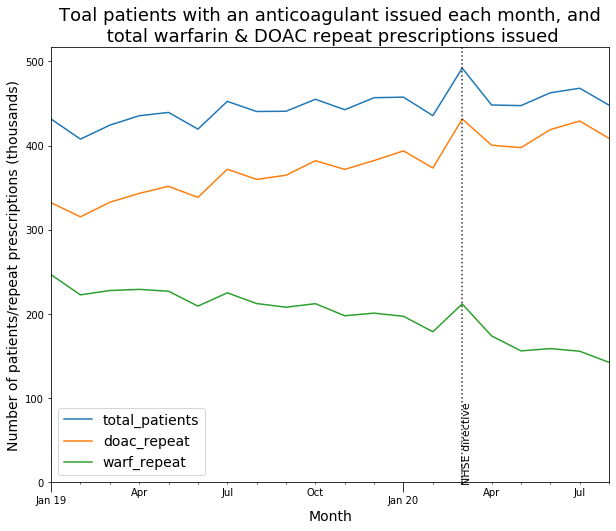

In [8]:
out = df5.copy()
out["issuemonth"] = pd.to_datetime(out["issuemonth"])
out = out.set_index("issuemonth")

# export data to csv
out.replace([1,2,3,4,5], np.NaN).to_csv(os.path.join("..","output","warf_doac_repeats.csv"))


dfp = out[["total_patients","doac_repeat","warf_repeat"]]
    
#display(Markdown(f"## Patients with an anticoagulant issued each month, and of whom, how many were on a warfarin or DOAC repeat prescription"))
titles = ["Toal patients with an anticoagulant issued each month, and\n total warfarin & DOAC repeat prescriptions issued"]
plot_line_chart([dfp], titles, ylabels={0:"Number of patients/repeat prescriptions"})

# Prescriptions issued on same day, and Repeats initiated on same day

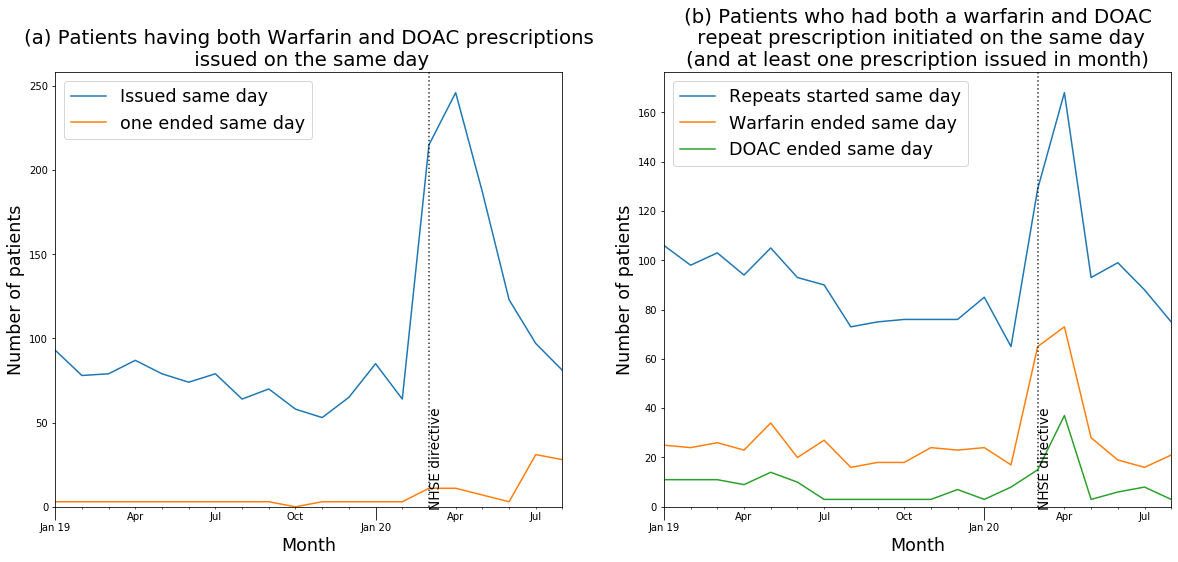

In [9]:
# (a) duplicate issues       
dfp1 = out4[["Duplicate_issues", "one_cancelled"]].replace([1,2,3,4,5], 3) # suppress low values
dfp1 = dfp1.rename(columns={"Duplicate_issues": "Issued same day", "one_cancelled":"one ended same day"})

# export data to csv
dfp1.replace([1,2,3,4,5], np.NaN).to_csv(os.path.join("..","output","same_day_issues.csv"))


# (b) duplicate repeats
out = df5.copy()
out["issuemonth"] = pd.to_datetime(out["issuemonth"])
out = out.set_index("issuemonth")
dfp2 = out[["started_same_date", "warfarin_cancelled", "doac_cancelled"]].replace([1,2,3,4,5], 3) # suppress low values
dfp2 = dfp2.rename(columns={"started_same_date": "Repeats started same day", 
                            "warfarin_cancelled":"Warfarin ended same day",
                            "doac_cancelled":"DOAC ended same day"})

# export data to csv
dfp2.replace([1,2,3,4,5], np.NaN).to_csv(os.path.join("..","output","same_day_repeats.csv"))


# plot charts
titles = ["(a) Patients having both Warfarin and DOAC prescriptions\n issued on the same day",
          "(b) Patients who had both a warfarin and DOAC\n repeat prescription initiated on the same day\n(and at least one prescription issued in month)"]
 
dfs = [dfp1, dfp2]

plot_line_chart(dfs, titles, loc="upper left")

## Patients starting a DOAC repeat per month, and of whom, how many switched from Warfarin
### This is repeats only and does not take into account any prescriptions being issued

In [21]:
# DOAC repeats initiated per month
sql1 = f'''SELECT
Patient_ID,
DATEFROMPARTS(YEAR(StartDate),MONTH(StartDate),1) AS doacStartmonth,
MAX(StartDate) AS latest_start
INTO #doacR
FROM
  MedicationRepeat
WHERE
  StartDate >= '20190101' AND
  StartDate < DATEFROMPARTS(YEAR(GETDATE()),MONTH(GETDATE()),1) AND -- select only repeats occurring up to end of last full month
  MultilexDrug_ID in {doac}  
GROUP BY 
Patient_ID,
DATEFROMPARTS(YEAR(StartDate),MONTH(StartDate),1)'''


# Check which patients had previous Warfarin and DOAC repeats
sql2 = f'''SELECT DISTINCT
Patient_ID,
CASE WHEN MultilexDrug_ID in {warf} THEN 'warfarin' ELSE 'DOAC' END AS 'anticoag',
DATEFROMPARTS(YEAR(EndDate),MONTH(EndDate),1) AS Endmonth,
MIN(StartDate) AS earliest_start
INTO #warfdoac
FROM
  MedicationRepeat
WHERE
  EndDate >= '20180601' AND
  StartDate < DATEFROMPARTS(YEAR(GETDATE()),MONTH(GETDATE()),1) AND -- select only repeats occurring up to end of last full month
  (MultilexDrug_ID in {warf} OR MultilexDrug_ID in {doac})
GROUP BY 
Patient_ID,
CASE WHEN MultilexDrug_ID in {warf} THEN 'warfarin' ELSE 'DOAC' END,
DATEFROMPARTS(YEAR(EndDate),MONTH(EndDate),1)'''


# join DOAC repeats to previous warfarin and DOAC repeats
sql3 = f'''
SELECT d.Patient_ID, 
doacStartmonth,
MAX(CASE WHEN w.Endmonth IS NOT NULL THEN 1 ELSE 0 END) AS switch_flag, -- indicates patient was on warfarin
MIN(CASE WHEN d2.Endmonth IS NULL THEN 1 ELSE 0 END) AS new_flag -- indicates patient was not previously on doac
INTO #out
FROM #doacR d
LEFT JOIN (SELECT * FROM #warfdoac WHERE anticoag='DOAC') d2 
    ON d.Patient_ID = d2.Patient_ID 
    AND (DATEDIFF(month, d2.Endmonth, d.doacStartmonth) BETWEEN 0 AND 3 ) --- only count as a new repeat where no previous repeat ended within 3mo
    AND d.latest_start != d2.earliest_start  --- if one repeat ends in same month, don't count it as a previous repeat
LEFT JOIN (SELECT * FROM #warfdoac WHERE anticoag='warfarin') w 
    ON d.Patient_ID = w.Patient_ID 
    AND DATEDIFF(month, w.Endmonth, d.doacStartmonth) BETWEEN 0 AND 3  --- only count as a switch where doac repeat started within 3mo of warf repeat end

GROUP BY d.Patient_ID, doacStartmonth
'''

query = f'''SELECT 
doacStartmonth, switch_flag, new_flag, COUNT(DISTINCT Patient_ID) AS patient_count
FROM #out
GROUP BY doacStartmonth, switch_flag, new_flag'''

with closing_connection(dbconn) as connection:
    connection.execute(sql1)
    connection.execute(sql2)
    
    # insert linkable data into warfarin table if using dummy data
    if 'OPENCoronaExport' in dbconn:
        date_fields=["latest_start"]
        dummy_data = generate_dummy_data(date_fields, month_field="latest_start")
        # small fixes to dummy data:
        dummy_data = dummy_data.rename(columns={"latest_start_month":"doacStartmonth"})
        insert_dummy_data(dummy_data, "#doacR")
        
        date_fields=["earliest_start", "EndDate"]
        choices={"anticoag":["warfarin","DOAC"]}
        dummy_data = generate_dummy_data(date_fields, month_field="EndDate", multiple_choice=choices)
        # small fixes to dummy data:
        dummy_data = dummy_data.rename(columns={"EndDate_month":"Endmonth"})
        dummy_data["earliest_start"] = np.where(dummy_data["EndDate"]<dummy_data["earliest_start"],dummy_data["EndDate"], dummy_data["earliest_start"])
        dummy_data = dummy_data.drop("EndDate", axis=1)
        insert_dummy_data(dummy_data, "#warfdoac")
    
    connection.execute(sql3)
    df6 = pd.read_sql(query, connection)


### other analyses to do
### patient had warfarin repeat re-instated while doac still live

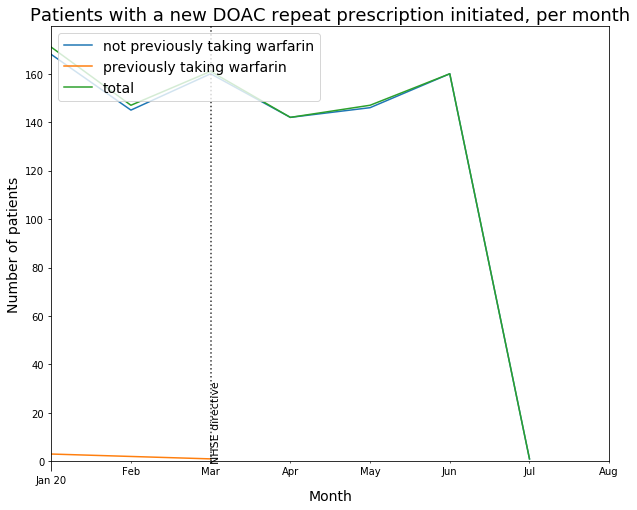

switch_flag,total (thousands),previously taking warfarin (%)
doacStartmonth,,
Jan 20,0.2,1.8
Feb 20,0.1,1.4
Mar 20,0.2,0.6
Apr 20,0.1,NaN
May 20,0.1,0.7
Jun 20,0.2,NaN
Jul 20,0.0,NaN


In [22]:
dfp = df6.loc[(df6["new_flag"]==1)]
dfp = dfp.groupby(["doacStartmonth", "switch_flag"])[["patient_count"]].sum().unstack().droplevel(0, axis=1)
dfp = dfp.rename(columns={0:"not previously taking warfarin", 1:"previously taking warfarin"})
dfp["total"] = dfp.sum(axis=1)

# export data to csv
dfp.replace([1,2,3,4,5], np.NaN).to_csv(os.path.join("..","output","doac_repeats.csv"))


titles = ["Patients with a new DOAC repeat prescription initiated, per month"]
plot_line_chart([dfp], titles, loc='upper left')

# calculate table of percentages
percents = dfp.copy()
percents.index = pd.to_datetime(percents.index).strftime('%b %y')
percents["total (thousands)"] = (percents["total"]/1000).round(1)
cols = ["not previously taking warfarin", "previously taking warfarin"]
percents["previously taking warfarin (%)"] = (100*percents["previously taking warfarin"]/percents["total"]).round(1)
display(percents.drop(cols, 1).drop("total", 1))


## Extract patients on Warfarin during baseline and count how many switched to DOAC

In [19]:
def switching(dates):

    b_start_2020, b_end_2020, f_end_2020 = dates[0], dates[1], dates[2]
    b_start_2019, b_end_2019, f_end_2019 = dates[3], dates[4], dates[5]

    # Warfarin and DOAC patients in baseline period
    sql1 = f'''SELECT
    Patient_ID,
    CASE WHEN StartDate >= '{b_start_2020}' AND StartDate < '{b_end_2020}' THEN '2020' ELSE '2019' END AS year,
    CASE WHEN MultilexDrug_ID in {warf} THEN 'warfarin' ELSE 'DOAC' END AS 'anticoag',
    MAX(StartDate) AS LatestIssue
    INTO #baseline
    FROM
      MedicationIssue
    WHERE
      ((StartDate >= '{b_start_2019}' AND StartDate < '{b_end_2019}') OR (StartDate >= '{b_start_2020}' AND StartDate < '{b_end_2020}')) AND
      (MultilexDrug_ID in {warf} OR MultilexDrug_ID in {doac})
    GROUP BY Patient_ID, CASE WHEN StartDate >= '{b_start_2020}' AND StartDate < '{b_end_2020}' THEN '2020' ELSE '2019' END,
      CASE WHEN MultilexDrug_ID in {warf} THEN 'warfarin' ELSE 'DOAC' END'''
     
    # DOAC patients in follow up period - detailed
    sql2a = f'''SELECT DISTINCT
    Patient_ID,
    CASE WHEN StartDate BETWEEN '{b_end_2020}' AND '{f_end_2020}' THEN '2020' ELSE '2019' END AS year,
    MultilexDrug_ID,
    StartDate
    INTO #doac_fu
    FROM
      MedicationIssue
    WHERE
      (StartDate BETWEEN '{b_end_2019}' AND '{f_end_2019}' OR StartDate BETWEEN '{b_end_2020}' AND '{f_end_2020}') AND
      MultilexDrug_ID in {doac}'''
    
    # DOAC patients in follow up period - summarised
    sql2b = f'''SELECT
    Patient_ID,
    year,
    MIN(StartDate) AS doacStart
    INTO #doac
    FROM
      #doac_fu
    GROUP BY Patient_ID, year'''

    # DOAC patients - which types of DOACs are used
    sql3a = f'''SELECT
    Patient_ID,
    year,
    MultilexDrug_ID, -- there may be multiple per person so remove duplicates in next step using row_number
    ROW_NUMBER() OVER (PARTITION BY Patient_ID, year ORDER BY StartDate ASC) AS doacStartRank
    INTO #doac_type_a
    FROM
      #doac_fu
    '''

    sql3b = f'''SELECT -- fetch only the first DOAC prescribed per person to avoid creating duplicate rows
    Patient_ID,
    year,
    MultilexDrug_ID
    INTO #doac_type_b
    FROM
      #doac_type_a
    WHERE
      doacStartRank = 1
    '''

    # Warf patients in follow up period - to check who was still receiving warfarin
    sql4 = f'''SELECT
    Patient_ID,
    CASE WHEN StartDate BETWEEN '{b_end_2020}' AND '{f_end_2020}' THEN '2020' ELSE '2019' END AS year,
    MAX(StartDate) AS WarfLatestIssue
    INTO #warf2
    FROM
      MedicationIssue
    WHERE
      (StartDate BETWEEN '{b_end_2019}' AND '{f_end_2019}' OR StartDate BETWEEN '{b_end_2020}' AND '{f_end_2020}') AND
      MultilexDrug_ID in {warf}
    GROUP BY Patient_ID, CASE WHEN StartDate BETWEEN '{b_end_2020}' AND '{f_end_2020}' THEN '2020' ELSE '2019' END'''

    # INR tests, high INR values & TTRs (to count which patients had one in 3 month period)
    sql5 = f'''select
    Patient_ID,
    CASE WHEN ConsultationDate BETWEEN '{b_end_2020}' AND '{f_end_2020}' THEN '2020' ELSE '2019' END AS year,
    CASE WHEN CTV3Code = '42QE.' THEN 'INR' ELSE 'TTR' END AS test,
    MAX(CASE WHEN CTV3Code = '42QE.' AND NumericValue>=8 THEN 1 ELSE 0 END) AS high_inr_value
    INTO #inr
    FROM CodedEvent e
    WHERE e.CTV3Code IN ('42QE.', 'Xaa68')
    AND (ConsultationDate BETWEEN '{b_end_2019}' AND '{f_end_2019}' OR ConsultationDate BETWEEN '{b_end_2020}' AND '{f_end_2020}')
    GROUP BY Patient_ID,
    CASE WHEN ConsultationDate BETWEEN '{b_end_2020}' AND '{f_end_2020}' THEN '2020' ELSE '2019' END,
    CASE WHEN CTV3Code = '42QE.' THEN 'INR' ELSE 'TTR' END 
    '''

    # join warfarin and doac patients
    sql6 = f'''
    SELECT w.Patient_ID, w.year,
    w.LatestIssue AS WarfLatestIssue, 
    CASE WHEN w2.Patient_ID IS NOT NULL AND doacStart IS NULL THEN 1 ELSE 0 END AS continued_warfarin_flag,
    CASE WHEN d.doacStart IS NOT NULL THEN 1 ELSE 0 END AS switch_flag,
    CASE WHEN w2.WarfLatestIssue > doacStart THEN 1 ELSE 0 END AS switch_back_flag,
    DATEFROMPARTS(YEAR(d.doacStart),MONTH(d.doacStart),1) AS doacStartmonth,
    CASE WHEN i.Patient_ID IS NOT NULL THEN 1 ELSE 0 END AS inr_flag,
    CASE WHEN ttr.Patient_ID IS NOT NULL THEN 1 ELSE 0 END AS ttr_flag,
    CASE WHEN w2.Patient_ID IS NOT NULL AND doacStart IS NULL AND i.Patient_ID IS NOT NULL THEN 1 ELSE 0 END AS continued_warfarin_had_inr,
    CASE WHEN w2.Patient_ID IS NOT NULL AND doacStart IS NULL AND i.high_inr_value>0 THEN 1 ELSE 0 END AS continued_warfarin_had_high_inr,
    CASE WHEN w2.Patient_ID IS NOT NULL AND doacStart IS NULL AND ttr.Patient_ID IS NOT NULL THEN 1 ELSE 0 END AS continued_warfarin_had_ttr,
    t.MultilexDrug_ID AS first_doac_type
    INTO #out
    FROM #baseline w
    LEFT JOIN #baseline dp ON dp.Patient_ID = w.Patient_ID AND dp.year = w.year AND dp.anticoag = 'DOAC' -- doac in baseline period (exclude these patients)
    LEFT JOIN #doac d ON d.Patient_ID = w.Patient_ID AND d.year = w.year -- doac in follow up period
    LEFT JOIN #warf2 w2 ON w.Patient_ID = w2.Patient_ID AND w.year = w2.year -- warfarin in follow up period
    LEFT JOIN #doac_type_b t ON w.Patient_ID = t.Patient_ID AND w.year = t.year-- doac type
    LEFT JOIN #inr i ON w.Patient_ID = i.Patient_ID AND i.test='INR'  AND w.year = i.year   -- INR tests
    LEFT JOIN #inr ttr ON w.Patient_ID = ttr.Patient_ID AND ttr.test='TTR'  AND w.year = ttr.year   -- INR TTRs recorded

    WHERE w.anticoag = 'warfarin' AND
      dp.Patient_ID IS NULL -- exclude pts who have already had doacs in baseline period

    ORDER BY d.Patient_ID
    ''' 

    # output summary data for switching and testing
    query = f'''
    SELECT 
    year,
    COUNT(DISTINCT Patient_ID) AS baseline_warfarin_patients,
    SUM(continued_warfarin_flag) AS continued_warfarin_flag,
    SUM(switch_flag) AS switch_flag,
    SUM(switch_back_flag) AS switch_back_flag,
    SUM(inr_flag) AS inr_count,
    SUM(ttr_flag) AS ttr_count,
    SUM(continued_warfarin_had_inr) AS continued_warfarin_had_inr,
    SUM(continued_warfarin_had_inr) AS continued_warfarin_had_high_inr,
    SUM(continued_warfarin_had_ttr) AS continued_warfarin_had_ttr
    FROM #out
    GROUP BY year
    '''
    
    # output summary of doac types
    query2 = f'''
    SELECT 
    first_doac_type,
    year,
    COUNT(DISTINCT Patient_ID) AS patient_count
    FROM #out
    WHERE switch_flag = 1
    GROUP BY first_doac_type, year
    '''

    with closing_connection(dbconn) as connection:
        connection.execute(sql1)
        connection.execute(sql2a)
        connection.execute(sql2b)
        connection.execute(sql3a)
        connection.execute(sql3b)
        connection.execute(sql4)
        connection.execute(sql5)
        # insert linkable data into warfarin table if using dummy data
        if 'OPENCoronaExport' in dbconn:
            # #out table (not very useful but faster than adding to several temp tables!)
            date_fields=["WarfLatestIssue", "doacStart"]
            multiple_choice={"year":['2019','2020']}
            exclusive_choices={"continued_warfarin_flag":[0,1],"switch_flag":[0,1],"switch_back_flag":[0,1],"inr_flag":[0,1],"ttr_flag":[0,1],
                               "continued_warfarin_had_inr":[0,1],"continued_warfarin_had_ttr":[0,1],
                               "first_doac_type":list(doac)}
            dummy_data = generate_dummy_data(date_fields, month_field="doacStart", multiple_choice=multiple_choice, exclusive_choices=exclusive_choices)
            # small fixes to dummy data:
            dummy_data = dummy_data.rename(columns={"doacStart_month":"doacStartmonth"})
            dummy_data = dummy_data.drop("doacStart", axis=1)
            insert_dummy_data(dummy_data, "#out")

        connection.execute(sql6)
        out1 = pd.read_sql(query, connection)
        out2 = pd.read_sql(query2, connection)
        display("completed run")
        
        return out1, out2

In [20]:
# Periods of interest:

## baseline Dec-Feb, follow-up March-May
dates1 = ['20191201', '20200301', '20200531','20181201', '20190301', '20190531']
## baseline March-May, follow-up June-Oct
dates2 = ['20200301', '20200601', '20200831','20190301', '20190601', '20190831']

df7, df8 = switching(dates1)
df9, df10 = switching(dates2)

ProgrammingError: Attempt to use a closed connection.

In [16]:
def summarise_switching(df, p):
    '''
    Summarise patients on Warfarin during baseline and how many switched to DOAC during follow-up, for 2019 vs 2020
    
    INPUTS:
    df (dataframe): summary figures without percentages
    p (int): period (1 or 2 corresponding to dates1/dates2 above)
    
    OUTPUTS:
    out (df): summary data
    '''
    
    out = df.copy()
    out["period"] = np.where(p==1, "March-May", "June-Aug")
    out["baseline warfarin patients (thousands)"] = (out["baseline_warfarin_patients"]/1000).round(1)
    out["switched (thousands)"] = (out["switch_flag"]/1000).round(1)
    for c in ["switch_flag","continued_warfarin_flag"]:
        c2 = c.replace("_flag","")
        out[f"{c2} (%)"] = (100*out[c]/out["baseline_warfarin_patients"]).round(1)

    out["switched back (% of switchers)"] = (100*out["switch_back_flag"]/out["switch_flag"]).round(1)

    for c in ["continued_warfarin_had_inr","continued_warfarin_had_ttr"]:
        c2 = c.replace("continued_warfarin_","")
        out[f"{c2} (% of continued)"] = (100*out[c]/out["continued_warfarin_flag"]).round(1)

    out = out.drop(["continued_warfarin_had_inr","continued_warfarin_had_ttr","switch_flag", "baseline_warfarin_patients", "continued_warfarin_flag"], 1)
    out = out.rename(columns={"switch_flag":"switched"}).sort_values(by="year")
    return out

In [17]:
display(Markdown(f"# Patients switching from Warfarin to DOAC during the pandemic versus the previous year"))

out = pd.concat([summarise_switching(df7, 1), summarise_switching(df9, 2)])
out.to_csv((os.path.join("..","output","doac_switchers.csv")))
out

# Patients switching from Warfarin to DOAC during the pandemic versus the previous year

,year,period,baseline warfarin patients (thousands),switched (thousands),switch (%),continued_warfarin (%),switched back (% of switchers),had_inr (% of continued),had_ttr (% of continued)
0,2019,March-May,195.0,6.9,3.5,90.9,4.1,83.7,37.9
1,2020,March-May,164.0,20.0,12.2,83.0,5.8,80.1,38.6
0,2019,June-Aug,185.9,5.9,3.2,91.4,4.4,82.4,39.1
1,2020,June-Aug,143.2,6.3,4.4,89.5,4.7,78.8,39.2


In [18]:
display(Markdown(f"# Which DOACs are warfarin patients switched to?"))
        
def doac_types(df, p):
    '''
    Summarise which DOACs Warfarin patients are switched to
    
    INPUTS:
    df (dataframe): summary figures without percentages
    p (int): period (1 or 2 corresponding to dates1/dates2 above)
    
    OUTPUTS:
    out (df): summary data
    '''
    out = df.copy()
    out["period"] = np.where(p==1, "March-May", "June-Aug")
    out = out.merge(doac_full, left_on="first_doac_type", right_on="MultilexDrug_ID")[["year", "period", "chemical", "patient_count"]]
    out = out.groupby(["year","period","chemical"]).sum().sort_values(by="patient_count", ascending=False).unstack(level=0)
    for year in ["2019", "2020"]:
        out[("%", year)] = (100*out[("patient_count", year)]/out[("patient_count", year)].sum()).round(1)
    out["patient_count"] = 10*(out["patient_count"]/10).round(0)
    out = out.stack(level=1).reset_index().set_index(["period","year","chemical"])
    return out

doacs = doac_types(df8, 1).append(doac_types(df10, 2))
doacs.sort_index().to_csv((os.path.join("..","output","doac_types.csv")))
out = doacs.stack().unstack(level=2).unstack().sort_index(ascending=False)[["Apixaban","Edoxaban","Rivaroxaban","Dabigatran etexilate"]]
out

# Which DOACs are warfarin patients switched to?

chemical            Apixaban            Edoxaban         Rivaroxaban        \
               patient_count     % patient_count     % patient_count     %   
period    year                                                               
March-May 2020        6710.0  33.5        7620.0  38.1        5550.0  27.7   
          2019        3510.0  51.2        1040.0  15.2        2180.0  31.8   
June-Aug  2020        2550.0  40.3        2120.0  33.5        1620.0  25.6   
          2019        2900.0  49.4        1110.0  18.9        1760.0  30.0   

chemical       Dabigatran etexilate       
                      patient_count    %  
period    year                            
March-May 2020                120.0  0.6  
          2019                120.0  1.8  
June-Aug  2020                 40.0  0.6  
          2019                 90.0  1.6

In [18]:
# High INRs - code checks
#- how many are numeric vs "high INR"
#- how many are exacly 8, or missing a value

sql = f'''select 
DATEFROMPARTS(YEAR(ConsultationDate), MONTH(ConsultationDate),1) AS month,
CASE WHEN CTV3Code in {inr_codes} THEN 'inr' ELSE 'high_inr' END AS codedevent,
CASE WHEN CTV3Code in {inr_codes} AND NumericValue > 100 THEN 'over 100'
  WHEN CTV3Code in {inr_codes} AND NumericValue > 8 THEN 'over 8'
  WHEN CTV3Code in {inr_codes} AND NumericValue = 8 THEN '8 exactly' 
  WHEN CTV3Code in {inr_codes} AND NumericValue < 8 THEN 'under 8'
  WHEN CTV3Code in {inr_codes} AND NumericValue IS NULL THEN 'no value' 
  WHEN CTV3Code in {inr_codes} AND NumericValue IN (0,-1) THEN 'no value' 
  ELSE 'high-INR' END AS classification,
COUNT (DISTINCT Patient_ID) AS pt_count,
COUNT(*) as count
FROM CodedEvent e
WHERE (e.CTV3Code in {inr_codes} OR e.CTV3Code in {high_inr})
AND ConsultationDate >= '20200101'
GROUP BY 
DATEFROMPARTS(YEAR(ConsultationDate), MONTH(ConsultationDate),1),
CASE WHEN CTV3Code in {inr_codes} THEN 'inr' ELSE 'high_inr' END,
CASE WHEN CTV3Code in {inr_codes} AND NumericValue > 100 THEN 'over 100'
  WHEN CTV3Code in {inr_codes} AND NumericValue > 8 THEN 'over 8'
  WHEN CTV3Code in {inr_codes} AND NumericValue = 8 THEN '8 exactly' 
  WHEN CTV3Code in {inr_codes} AND NumericValue < 8 THEN 'under 8'
  WHEN CTV3Code in {inr_codes} AND NumericValue IS NULL THEN 'no value' 
  WHEN CTV3Code in {inr_codes} AND NumericValue IN (0,-1) THEN 'no value' 
  ELSE 'high-INR' END
'''

with closing_connection(dbconn) as connection:
    inr_test_test = pd.read_sql(sql, connection)
    
inr_test_test

,month,codedevent,classification,pt_count,count
0,2020-03-01,inr,under 8,1,1


# INR testing

In [7]:
base = date(2019, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(20)]

df_out = pd.DataFrame()
df_out2 = pd.DataFrame()


# Warfarin and DOAC patients and all issue dates
sqla = f'''SELECT 
Patient_ID,
MultilexDrug_ID,
StartDate
INTO #issues_all
FROM
  MedicationIssue
WHERE
  StartDate >= '20180901' AND
  (MultilexDrug_ID in {warf} OR MultilexDrug_ID in {doac})
GROUP BY Patient_ID, MultilexDrug_ID, StartDate
'''

# INR tests
sqlb = f'''select 
Patient_ID,
ConsultationDate,
CASE WHEN CTV3Code in {inr_codes} THEN 'inr' ELSE 'high_inr' END AS codedevent,
MAX(NumericValue) AS highest_value,
COUNT(*) AS test_count
INTO #inr_all
FROM CodedEvent e
WHERE (e.CTV3Code in {inr_codes} OR e.CTV3Code in {high_inr})
AND ConsultationDate >= {base}
GROUP BY Patient_ID, CASE WHEN CTV3Code in {inr_codes} THEN 'inr' ELSE 'high_inr' END, ConsultationDate
'''

# High INRs
sqlc = f'''select DISTINCT
Patient_ID,
ConsultationDate
INTO #high_inr_all
FROM #inr_all
WHERE (codedevent = 'high_inr' or (codedevent = 'inr' and highest_value >=8))
AND ConsultationDate >= {base}
'''


with closing_connection(dbconn) as connection:
    # set up common temp tables to query from for each date period
    connection.execute(sqla)
    connection.execute(sqlb)
    connection.execute(sqlc)
    
    # iterate over months, because when considering who is a warfarin patient we want to look over the last 3 months, which is complex if multiple months analysed together

    for month_date in date_list:    
    
        mindate = str(month_date).replace("-","")
        # first of following month to use as end date
        maxdate = str(month_date + relativedelta(months=1)).replace("-","")
        # for prescriptions, take 3 months previous to account for gap between a prescription and blood test
        mindate2 = str(month_date + relativedelta(months=-3)).replace("-","")

        # Warfarin patients and all issue dates
        sql1 = f'''SELECT 
        Patient_ID,
        MAX(StartDate) AS WarfLatestIssue
        INTO #warf
        FROM
          #issues_all
        WHERE
          StartDate >= '{mindate2}' AND StartDate < '{maxdate}' AND
          MultilexDrug_ID in {warf}
        GROUP BY Patient_ID
        '''

        # DOAC issues
        sql2 = f'''SELECT 
        Patient_ID,
        MAX(StartDate) AS doacLatestIssue
        INTO #doac
        FROM
          #issues_all
        WHERE
          StartDate >= '{mindate2}' AND StartDate < '{maxdate}' AND
          MultilexDrug_ID in {doac}
        GROUP BY Patient_ID
        '''

        # INR tests
        sql3 = f'''select
        Patient_ID,
        SUM(test_count) AS test_count
        INTO #inr
        FROM #inr_all
        WHERE codedevent = 'inr'
        AND ConsultationDate >= '{mindate}' AND ConsultationDate < '{maxdate}'
        GROUP BY Patient_ID
        '''
        
        # high INRs
        sql4 = f'''select
        Patient_ID
        INTO #high_inr
        FROM #high_inr_all
        WHERE ConsultationDate >= '{mindate}' AND ConsultationDate < '{maxdate}'
        GROUP BY Patient_ID
        '''

        # join tests to patients on warfarin
        query = f'''
        SELECT 
        '{month_date}' AS INR_month,
        SUM(inr.test_count) AS test_count,
        COUNT(DISTINCT inr.Patient_ID) AS patient_count,
        COUNT(DISTINCT w.Patient_ID) AS denominator
        FROM #warf w   
        LEFT JOIN #inr AS inr ON inr.Patient_ID = w.Patient_ID  -- iNR tests
        LEFT JOIN #doac d on w.Patient_ID = d.Patient_ID AND d.doacLatestIssue > w.warfLatestIssue -- check whether patient has switched to doac
        WHERE d.Patient_ID IS NULL -- exclude pts from denominator if they had doac more recently than warfarin
        '''
    
        # join high INRs to patients on warfarin
        query2 = f'''
        SELECT 
        '{month_date}' AS high_INR_month,
        COUNT(DISTINCT inr.Patient_ID) AS patient_count,
        COUNT(DISTINCT w.Patient_ID) AS denominator
        FROM #warf w   
        LEFT JOIN #high_inr AS inr ON inr.Patient_ID = w.Patient_ID  -- raised INRs
        LEFT JOIN #doac d on w.Patient_ID = d.Patient_ID AND d.doacLatestIssue > w.warfLatestIssue -- check whether patient has switched to doac
        WHERE d.Patient_ID IS NULL -- exclude pts from denominator if they had doac more recently than warfarin
        '''
        connection.execute(sql1)
        connection.execute(sql2)
        connection.execute(sql3)
        connection.execute(sql4)
        if 'OPENCoronaExport' in dbconn:
            connection.execute('''INSERT INTO #warf (Patient_ID, WarfLatestIssue)
            VALUES ('1486439', '20200201')''' )    
            connection.execute('''INSERT INTO #doac (Patient_ID, doacLatestIssue)
            VALUES ('1486439', '20200301')''' ) 
            connection.execute('''INSERT INTO #inr (Patient_ID)
            VALUES ('1486439')''' )   
        df = pd.read_sql(query, connection)
        df2 = pd.read_sql(query2, connection)
        connection.execute("DROP TABLE #warf")
        connection.execute("DROP TABLE #doac")
        connection.execute("DROP TABLE #inr")
        connection.execute("DROP TABLE #high_inr")
        df_out = pd.concat([df_out, df])
        df_out2 = pd.concat([df_out2, df2])
        display(f"{mindate}... complete!")


'20190101... complete!'

'20190201... complete!'

'20190301... complete!'

'20190401... complete!'

'20190501... complete!'

'20190601... complete!'

'20190701... complete!'

'20190801... complete!'

'20190901... complete!'

'20191001... complete!'

'20191101... complete!'

'20191201... complete!'

'20200101... complete!'

'20200201... complete!'

'20200301... complete!'

'20200401... complete!'

'20200501... complete!'

'20200601... complete!'

'20200701... complete!'

'20200801... complete!'

In [42]:
df_out.to_csv(os.path.join("..","output","inr_testing.csv"))

## INR tests for patients on Warfarin (and not DOAC) in previous 3 months

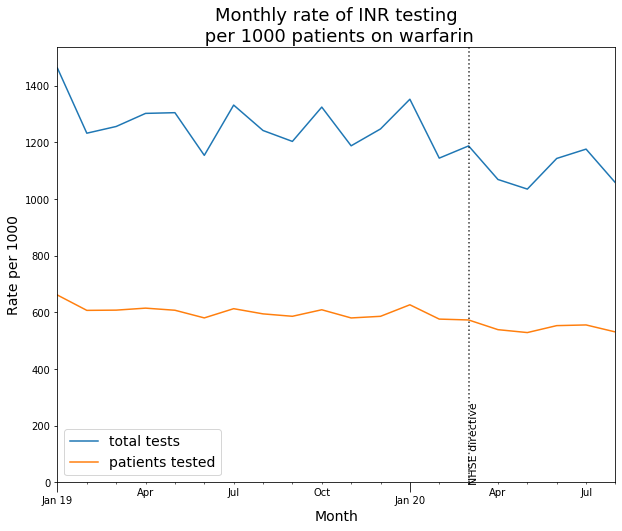

In [21]:
dfp = df_out.copy()
dfp["INR_month"] = pd.to_datetime(dfp["INR_month"])
dfp = dfp.set_index("INR_month")

dfp["patients tested"] = 1000*dfp["patient_count"]/dfp["denominator"]
dfp["total tests"] = 1000*dfp["test_count"]/dfp["denominator"]
titles = ["Monthly rate of INR testing\n per 1000 patients on warfarin"]
plot_line_chart([dfp[["total tests","patients tested"]]], titles, 
                ylabels={0:"Rate per 1000"})

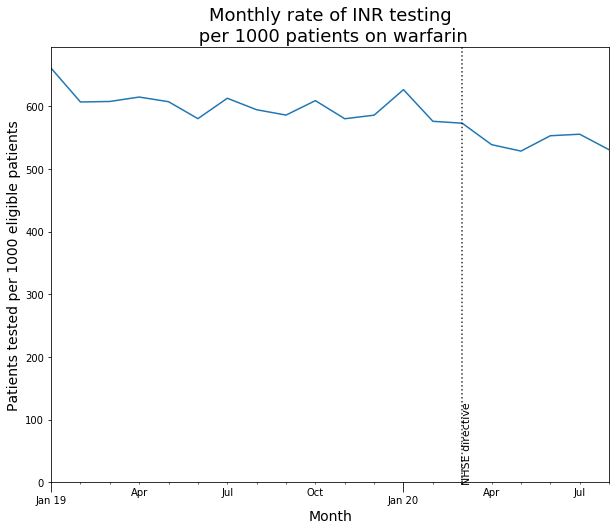

In [23]:
titles = ["Monthly rate of INR testing\n per 1000 patients on warfarin"]
plot_line_chart([dfp[["patients tested"]]], titles, 
                ylabels={0:"Patients tested per 1000 eligible patients"})

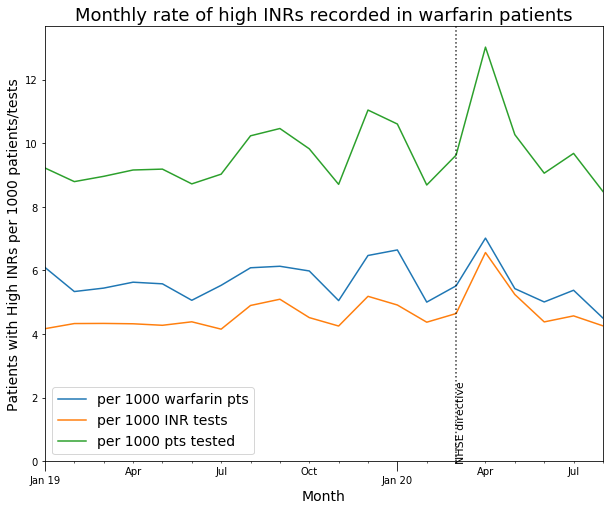

In [24]:
dfp = df_out.drop("denominator",1).merge(df_out2, left_on="INR_month", right_on="high_INR_month", suffixes=["_tests","_high"]).drop("INR_month",1)
dfp["high_INR_month"] = pd.to_datetime(dfp["high_INR_month"])
dfp = dfp.set_index("high_INR_month")

dfp["per 1000 warfarin pts"] = 1000*dfp["patient_count_high"]/dfp["denominator"]
dfp["per 1000 INR tests"] = 1000*dfp["patient_count_high"]/dfp["test_count"]
dfp["per 1000 pts tested"] = 1000*dfp["patient_count_high"]/dfp["patient_count_tests"]

titles = ["Monthly rate of high INRs recorded in warfarin patients"]
plot_line_chart([dfp[["per 1000 warfarin pts", "per 1000 INR tests", "per 1000 pts tested"]]], titles, 
                ylabels={0:"Patients with High INRs per 1000 patients/tests"})

## Summary INR testing data

In [25]:
tests = df_out.copy()
tests["rate per 1000"] = 1000*tests["patient_count"]/tests["denominator"]
premarch = tests.loc[tests["INR_month"]<="2020-03-01"]["rate per 1000"].mean().round(1)
postmarch = tests.loc[tests["INR_month"]>"2020-03-01"]["rate per 1000"].mean().round(1)
diff = (premarch-postmarch).round(1)
diffp = (100*diff/premarch).round(1)
display(Markdown(f'''Mean testing rate Jan 2019-March 2020:   **{premarch}** patients tested per 1000 eligible patients per month\n
Mean testing rate April-Aug 2020:   **{postmarch}** patients tested per 1000 eligible patients per month\n
Difference in monthly rate:   **{diff}** patients per 1000 eligible patients ({diffp}% reduction)'''))

Mean testing rate Jan 2019-March 2020:   **601.5** patients tested per 1000 eligible patients per month

Mean testing rate April-Aug 2020:   **541.4** patients tested per 1000 eligible patients per month

Difference in monthly rate:   **60.1** patients per 1000 eligible patients (10.0% reduction)

# Time in therapeutic range

In [28]:
# check for presence of each possible INR and TTR code
query = '''select ctv3code, count(*) from CodedEvent
        where ctv3code IN ('42QE.','YavzQ', '42QE2', 'Xaa68', '.42QE','Y7FIy',
        'XaZqW', '66Q80', -- above range
        'XaPfs', '9k25.', -- below range
        'XaPBw', '9k22.') -- within range
        AND YEAR(ConsultationDate) = 2020
        GROUP BY ctv3code
        '''

with closing_connection(dbconn) as connection:
    df = pd.read_sql(query, connection)
df

,ctv3code,
0,XaPfs,9565
1,XaZqW,6829
2,XaPBw,30508
3,Xaa68,731506
4,42QE.,1881104


In [29]:

# recorded TTR values for INR tests
sql1 = '''SELECT  -- coded events for INR TTR
Patient_ID, NumericValue, 
DATEFROMPARTS(YEAR(ConsultationDate), MONTH(ConsultationDate),1) AS month
INTO #ttr
FROM CodedEvent
WHERE CTV3Code = 'Xaa68' -- INR Time in therapeutic range
AND ConsultationDate BETWEEN '20190301' AND '20200830'
'''

# Warfarin patients and all issue dates
sql2 = f'''SELECT 
Patient_ID,
DATEFROMPARTS(YEAR(StartDate), MONTH(StartDate),1) AS month
INTO #warfissue
FROM
  MedicationIssue
WHERE
  StartDate BETWEEN '20181201' AND '20200830' AND
  MultilexDrug_ID in {warf}
GROUP BY Patient_ID, DATEFROMPARTS(YEAR(StartDate), MONTH(StartDate),1)
'''

# join tests to patients on warfarin
sql3 = '''
SELECT DISTINCT -- use distinct here to resolve duplicates introduced in join
t.month AS month,
t.Patient_ID,
t.NumericValue
INTO #warftests
FROM #ttr AS t 
INNER JOIN #warfissue w ON t.Patient_ID = w.Patient_ID 
  AND DATEDIFF(month, w.month, t.month) <= 3 -- test within 3 months of a warfarin issue
'''

# join tests to tests occurring in the following month
sql4 = '''
SELECT 
t.month AS month,
t.Patient_ID,
t.NumericValue, 
PERCENT_RANK() OVER (PARTITION BY t.month ORDER BY t.NumericValue) AS current_rank,
CASE WHEN p.Patient_ID IS NULL THEN 0 ELSE 1 END AS tested_next_month
INTO #out
FROM #warftests AS t 
LEFT JOIN (SELECT Patient_ID, month, AVG(NumericValue) AS mean_value FROM #warftests GROUP BY Patient_ID, month) p 
  ON t.Patient_ID = p.Patient_ID 
  AND DATEDIFF(month, t.month, p.month) = 1 -- test following month
'''

query = '''
SELECT 
month,
tested_next_month,
AVG(current_rank) AS rank,
AVG(NumericValue) AS mean_value,
STDEV(NumericValue) AS stdev,
COUNT(*) AS test_count,
COUNT(DISTINCT Patient_ID) AS patient_count
FROM #out
GROUP BY month, tested_next_month
'''

query2 = '''
SELECT 
month,
AVG(NumericValue) AS mean_value,
STDEV(NumericValue) AS stdev,
COUNT(*) AS test_count,
COUNT(DISTINCT Patient_ID) AS patient_count
FROM #out
GROUP BY month
'''

query3 = '''
SELECT 
month,
tested_next_month,
CASE WHEN NumericValue < 50 THEN '0-<50'
  WHEN NumericValue < 60 THEN '50-<60'
  WHEN NumericValue < 70 THEN '60-<70'
  WHEN NumericValue < 80 THEN '70-<80'
  WHEN NumericValue < 90 THEN '80-<90'
  ELSE '90-100' END AS value,
COUNT(*) AS test_count,
COUNT(DISTINCT Patient_ID) AS patient_count
FROM #out
GROUP BY month,tested_next_month,
CASE WHEN NumericValue < 50 THEN '0-<50'
  WHEN NumericValue < 60 THEN '50-<60'
  WHEN NumericValue < 70 THEN '60-<70'
  WHEN NumericValue < 80 THEN '70-<80'
  WHEN NumericValue < 90 THEN '80-<90'
  ELSE '90-100' END
'''

with closing_connection(dbconn) as connection:
    connection.execute(sql1)
    connection.execute(sql2)
    connection.execute(sql3)
    connection.execute(sql4)
    df_split = pd.read_sql(query, connection)
    df_overall = pd.read_sql(query2, connection)
    df_binned = pd.read_sql(query3, connection)

**Patient counts for each TTR range**

value,0-<50,50-<60,60-<70,70-<80,80-<90,90-100
month,,,,,,
2020-08-01,3748.0,4031.0,6642.0,8860.0,8991.0,8358.0


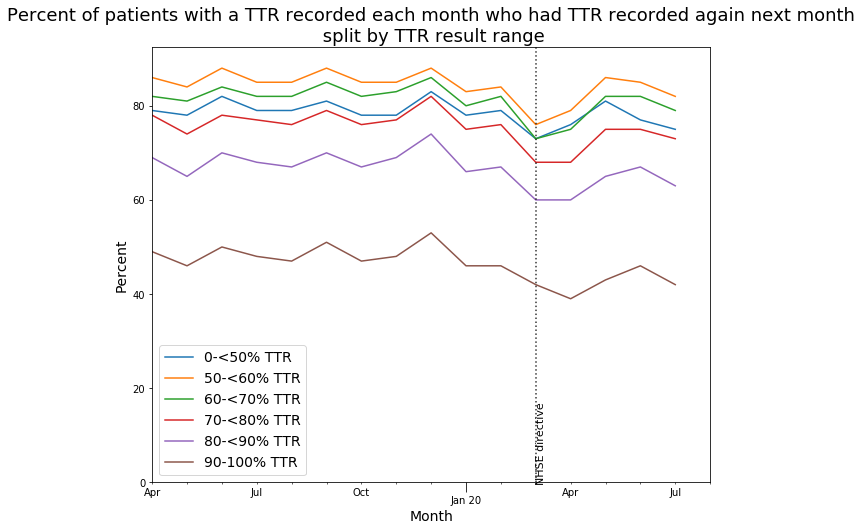

In [30]:
check = df_binned[df_binned["month"]>=date(2019,4,1)].sort_values(by="month").set_index(["month", "value", "tested_next_month"])[["patient_count"]].unstack().droplevel(level=0, axis=1)
check["total"] = check.sum(axis=1)
check["percent_tested"] = (100*check[1]/check["total"]).round(0)
display(Markdown("**Patient counts for each TTR range**"), check[["total"]].tail(6).unstack().droplevel(0, axis=1))
dfp = check[["percent_tested"]].unstack().droplevel(level=0, axis=1)
dfp = dfp.add_suffix("% TTR")

titles = ["Percent of patients with a TTR recorded each month who had TTR recorded again next month\n split by TTR result range"]
ylabels = {0:"Percent"}
plot_line_chart([dfp], titles, ylabels)

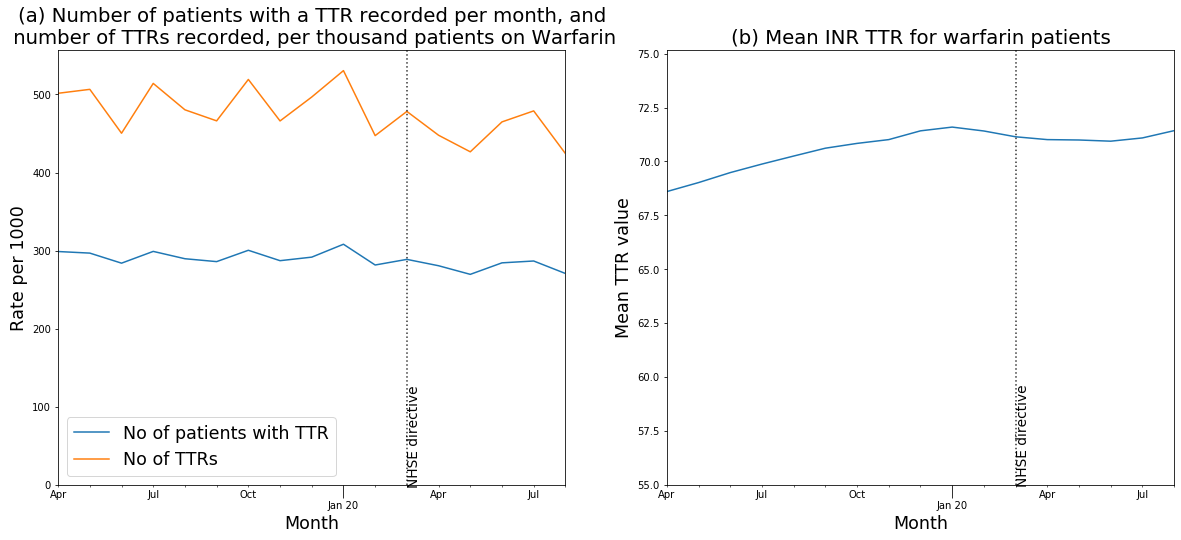

In [31]:
dfp = df_overall[df_overall["month"]>=date(2019,4,1)].sort_values(by="month").set_index(["month"])

dfp1 = dfp[["patient_count","test_count"]]

# get denominators (total warf patients) from previous query
denoms = df_out[["INR_month", "denominator"]].set_index("INR_month")
denoms.index = pd.to_datetime(denoms.index)
dfp1 = dfp1.join(denoms)
# calculate rates per 1000
dfp1["No of patients with TTR"] = 1000*dfp1["patient_count"]/dfp1["denominator"]
dfp1["No of TTRs"] = 1000*dfp1["test_count"]/dfp1["denominator"]

dfp1 = dfp1[["No of patients with TTR", "No of TTRs"]]
#dfp1 = dfp1.rename(columns={"patient_count":"No of patients tested","test_count":"No of tests"})

dfp2 = dfp[["mean_value"]]
titles = ["(a) Number of patients with a TTR recorded per month, and\n number of TTRs recorded, per thousand patients on Warfarin", 
          "(b) Mean INR TTR for warfarin patients"]
ylabels = {0:"Rate per 1000", 1:"Mean TTR value"}
ymins = {1:55}

plot_line_chart([dfp1, dfp2], titles=titles, ylabels=ylabels, ymins=ymins)

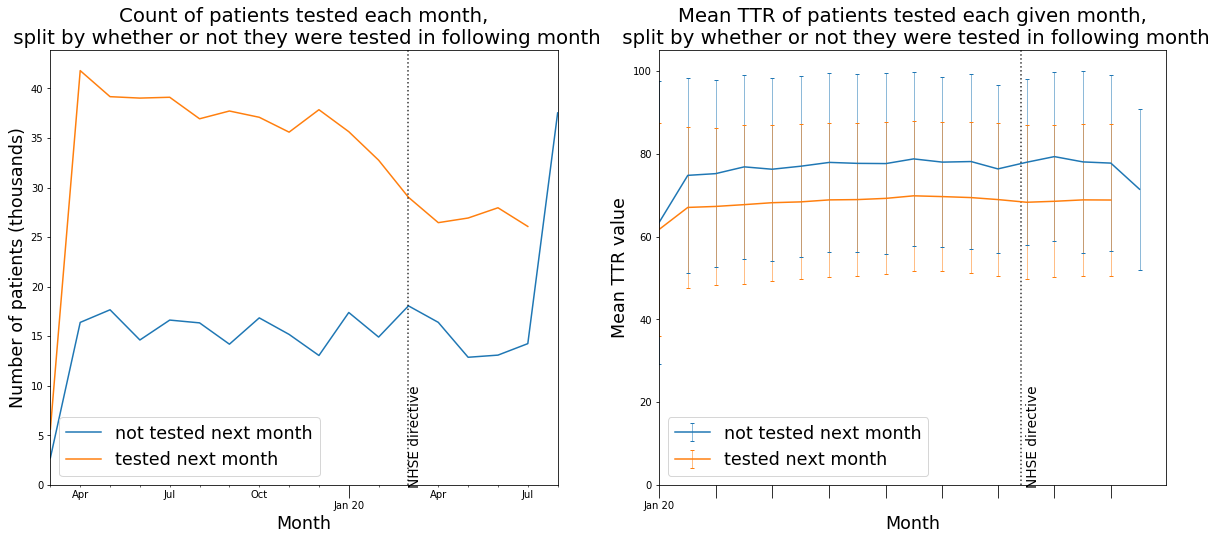

In [32]:
#dfp1 = df.groupby("month")[["patient_count","test_count"]].sum()
dfp1 = df_split.sort_values(by="month").set_index(["month","tested_next_month"])[["patient_count"]].unstack().droplevel(0, axis=1).rename(columns={0:"not tested next month", 1:"tested next month"})

dfp2 = df_split.sort_values(by="month").set_index(["month","tested_next_month"])[["mean_value","stdev"]].unstack()
dfp2 = dfp2.stack(level=0).unstack().rename(columns={0:"not tested next month", 1:"tested next month"})
dfp2.columns = dfp2.columns.map("_".join).str.replace("_mean_value","")


titles = ["Count of patients tested each month,\n split by whether or not they were tested in following month", 
          "Mean TTR of patients tested each given month,\n split by whether or not they were tested in following month"]

ylabels = {1:"Mean TTR value"}

plot_line_chart([dfp1, dfp2], titles, ylabels)